<a href="https://colab.research.google.com/github/vn322/Cod_future/blob/main/Random_Forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Введение

Random Forest является композицией (ансамблем) множества решающих деревьев, что позволяет снизить проблему переобучения и повысить точность в сравнении с одним деревом. Прогноз получается в результате агрегирования ответов множества деревьев. Тренировка деревьев происходит независимо друг от друга (на разных подмножествах), что не просто решает проблему построения одинаковых деревьев на одном и том же наборе данных, но и делает этот алгоритм весьма удобным для применения в системах распределённых вычислений. Вообще, идея бэггинга, предложенная Лео Брейманом и Адель Катлер, хорошо подходит для распределения вычислений.


Для бэггинга (независимого обучения алгоритмов классификации, где результат определяется голосованием) есть смысл использовать большое количество деревьев решений с достаточно большой глубиной. Во время классификации финальным результатом будет тот класс, за который проголосовало большинство деревьев, при условии, что одно дерево обладает одним голосом.


Так, например, если в задаче бинарной классификации была сформирована модель с 500 деревьями, среди которых 100 указывают на нулевой класс, а остальные 400 на первый класс, то в результате модель будет предсказывать именно первый класс. Если использовать Random Forest для задач регрессии, то подход выбора того решения, за которое проголосовало большинство деревьев будет неподходящим. Вместо этого происходит выбор среднего решения по всем деревьям.

В целом работа алгоритма проходит следующие этапы:

- Берётся подвыборка обучающей выборки  (возможно  с возвращением) – по ней строится дерево (для каждого дерева — своя подвыборка).
- Для построения каждого расщепления в дереве просматриваем используются свои случайные признаки.
- Выбираются наилучшие признак и расщепление по нему (по заранее заданному критерию). Дерево строится, как правило, до исчерпания выборки (пока в листьях не останутся представители только одного класса), но в современных реализациях есть параметры, которые ограничивают высоту дерева, число объектов в листьях и число объектов в подвыборке, при котором проводится расщепление.


Такая схема построения соответствует главному принципу ансамблирования (построению алгоритма машинного обучения на базе нескольких, в данном случае решающих деревьев): базовые алгоритмы должны быть хорошими и разнообразными (поэтому каждое дерево строится на своей обучающей выборке и при выборе расщеплений есть элемент случайности).


Random Forest (по причине независимого построения глубоких деревьев) требует  много ресурсов, а ограничение на глубину повредит точности (для решения сложных задач нужно построить много глубоких деревьев). Можно заметить, что время обучения деревьев возрастает приблизительно линейно их количеству.


Естественно, увеличение высоты (глубины) деревьев не самым лучшим образом сказывается на производительности, но повышает эффективность этого алгоритма (хотя и вместе с этим повышается склонность к переобучению). Слишком сильно бояться переобучения не следует, так как это будет скомпенсировано числом деревьев. Но и увлекаться тоже не следует. Везде важны оптимально подобранные параметры (гиперпараметры).

# Загрузка данных и библиотек

In [ ]:
# Экспорт необходимых для исследования библиотек
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 

from xgboost import XGBRFClassifier, XGBClassifier

In [ ]:
# Загрузка данных и првоерка их целостности
df = pd.read_csv('https://raw.githubusercontent.com/vn322/Sport-University/main/esport/high_diamond_ranked_10min.csv')
display(df.head(3), df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5


None

In [ ]:
df1 = df.copy() # произведём копирование датасета для защиты от случайного изменения

In [ ]:
df1.drop('gameId', axis=1, inplace=True)
df1.head(3)

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,0,28,2,1,9,6,11,0,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,0,12,1,0,5,5,5,0,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,0,15,0,0,7,11,4,1,1,0,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5


In [ ]:

# произведём резервное копирование очищенного датасета
df_big = df.copy()

In [ ]:
# выберем данные для дальнейшего исследования и создадим новый выборочный датасет
df_select = df[['blueWins','blueWardsPlaced', 'blueWardsDestroyed', 
                'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists', 
                'blueDragons', 'blueHeralds', 'blueTowersDestroyed', 
                'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled',
                'redWardsPlaced', 'redWardsDestroyed', 
                'redFirstBlood', 'redKills', 'redDeaths', 'redAssists', 
                'redDragons', 'redHeralds', 'redTowersDestroyed', 
                'redTotalMinionsKilled', 'redTotalJungleMinionsKilled']]
df_select.head(3)

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueTowersDestroyed,...,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redDragons,redHeralds,redTowersDestroyed,redTotalMinionsKilled,redTotalJungleMinionsKilled
0,0,28,2,1,9,6,11,0,0,0,...,6,0,6,9,8,0,0,0,197,55
1,0,12,1,0,5,5,5,0,0,0,...,1,1,5,5,2,1,1,1,240,52
2,0,15,0,0,7,11,4,1,0,0,...,3,1,11,7,14,0,0,0,203,28


Мультиколлинеарность не является проблемой для деревьев решений, но давайте убедимся сами и повторим разделение на полный и выборочный набор данных как в случае с регрессионной модели

In [ ]:
# удалим признаки с высокой мультиколлинеарностью.
df_select.drop(columns=['redKills', 'redDeaths', 'redFirstBlood'], 
               inplace=True)
df_select.columns

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Index(['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood',
       'blueKills', 'blueDeaths', 'blueAssists', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'redWardsPlaced', 'redWardsDestroyed',
       'redAssists', 'redDragons', 'redHeralds', 'redTowersDestroyed',
       'redTotalMinionsKilled', 'redTotalJungleMinionsKilled'],
      dtype='object')

# Создание набора функций для оценки продуктивности моделей

Эти функции сделаны для упрощения процесса исследования и избегания постоянного повторения одного и того же кода, поэтому вы можете потом использовать при проведении собственных исследований неизменными или внеся желаемые вам изменения

In [ ]:
# функция оценки модели

def evaluate_model(model, X_train, y_train, X_test, y_test, digits=4, 
                   figsize=(10,5), params=False): 

        
    # Get Predictions
    y_hat_test = model.predict(X_test)
    y_hat_train = model.predict(X_train)
    
    # Classification Report / Scores 

    print("****CLASSIFICATION REPORT - TRAINING DATA****")
    
    print(metrics.classification_report(y_train,y_hat_train, digits=digits))
    

    print("****CLASSIFICATION REPORT - TEST DATA****")
    
    print(metrics.classification_report(y_test,y_hat_test, digits=digits))

    print("****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****")

    
    fig, axes = plt.subplots(ncols=2, 
                             figsize=figsize)
    
    # Confusion Matrix
    metrics.ConfusionMatrixDisplay.from_estimator(model, X_test,
                                  y_test,normalize='true',
                                 cmap='Purples',ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    
    # Plot ROC Curve
    metrics.RocCurveDisplay.from_estimator(model,X_test,y_test,ax=axes[1])

    ax = axes[1]
    ax.legend()
    ax.plot([0,1],[0,1], ls='-')
    ax.grid()
    ax.set_title('ROC AUC Curve')
    
    plt.tight_layout()
    plt.show()
    
    if params == True:
        print("****MODEL PARAMETERS****")
        params = pd.DataFrame(pd.Series(model.get_params()))
        params.columns=['parameters']
        display(params)
        
    
def split_scale(df, target, scaler=StandardScaler()):
   
    
    
    # Separate X and y
    target = target
    y = df[target]
    X = df.drop(target, axis=1)

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    
    # Get list of column names
    cols = X_train.columns
    
    # Scale columns
    scaler = scaler
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=cols)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=cols)
    
    return X_train, X_test, y_train, y_test


def fit_eval(model, X_train, y_train, X_test, y_test, digits=4, 
             figsize=(10,5), params=False):

    model.fit(X_train, y_train)

    evaluate_model(model, X_train, y_train, X_test, y_test, digits=digits, 
                   figsize=figsize, params=params)
    
    return model

In [ ]:
# Create training and test data splits.
X_train_select, X_test_select, y_train_select, \
                y_test_select = split_scale(df_select, 'blueWins')
X_train_big, X_test_big, y_train_big, \
             y_test_big = split_scale(df_big, 'blueWins')

# Сравнение работы модели на наборах данных разной полноты.

Проведём оценку работы модели на выборочном наборе данных

****CLASSIFICATION REPORT - TRAINING DATA****
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      4203
           1     1.0000    1.0000    1.0000      4194

    accuracy                         1.0000      8397
   macro avg     1.0000    1.0000    1.0000      8397
weighted avg     1.0000    1.0000    1.0000      8397

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0     0.7212    0.7212    0.7212       746
           1     0.7174    0.7174    0.7174       736

    accuracy                         0.7193      1482
   macro avg     0.7193    0.7193    0.7193      1482
weighted avg     0.7193    0.7193    0.7193      1482

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


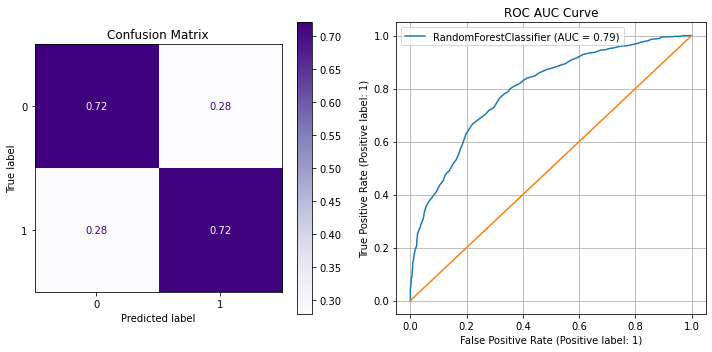

RandomForestClassifier(random_state=42)

In [ ]:
# применим случайный лес на выборочном наборе данных
fit_eval(RandomForestClassifier(random_state=42), X_train_select, \
         y_train_select, X_test_select, y_test_select)

Теперь посмотрим, что изменилось на полном наборе и убедимся, что продуктивность модели стала лучше.

****CLASSIFICATION REPORT - TRAINING DATA****
              precision    recall  f1-score   support

           0     0.9998    0.9998    0.9998      4203
           1     0.9998    0.9998    0.9998      4194

    accuracy                         0.9998      8397
   macro avg     0.9998    0.9998    0.9998      8397
weighted avg     0.9998    0.9998    0.9998      8397

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0     0.7180    0.7373    0.7275       746
           1     0.7263    0.7065    0.7163       736

    accuracy                         0.7220      1482
   macro avg     0.7221    0.7219    0.7219      1482
weighted avg     0.7221    0.7220    0.7219      1482

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


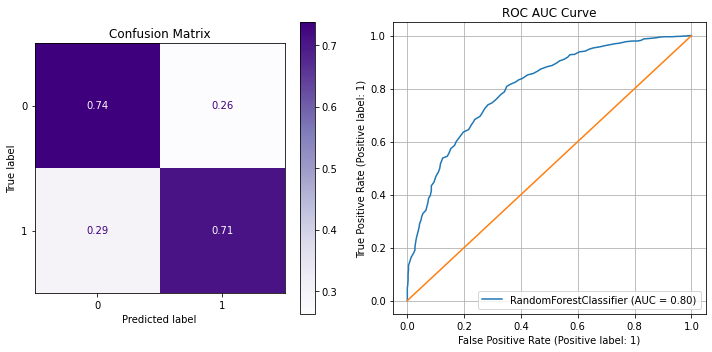

RandomForestClassifier(random_state=42)

In [ ]:
# применим алгоритм на полном наборе данных 
fit_eval(RandomForestClassifier(random_state=42), X_train_big, y_train_big, \
                                                  X_test_big, y_test_big)

Хотя оценки наших моделей случайного леса, запускаемых на тестовых данных, аналогичны тем, которые мы видели в нашей логистической регрессии, существует проблема переобучения (overfitting). Чтобы предотвратить overfitting, мы в идеале будем использовать gridsearch, чтобы подобрать оптимальные гиперпараметры для этой модели и этих данных.

# Градиентный бустинг случайного леса XGBoost: Random Forest
Применение на выборочном наборе данных (df_select)

****CLASSIFICATION REPORT - TRAINING DATA****
              precision    recall  f1-score   support

           0     0.7446    0.7235    0.7339      4203
           1     0.7306    0.7513    0.7408      4194

    accuracy                         0.7374      8397
   macro avg     0.7376    0.7374    0.7374      8397
weighted avg     0.7376    0.7374    0.7374      8397

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0     0.7328    0.6984    0.7152       746
           1     0.7082    0.7418    0.7246       736

    accuracy                         0.7200      1482
   macro avg     0.7205    0.7201    0.7199      1482
weighted avg     0.7206    0.7200    0.7199      1482

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


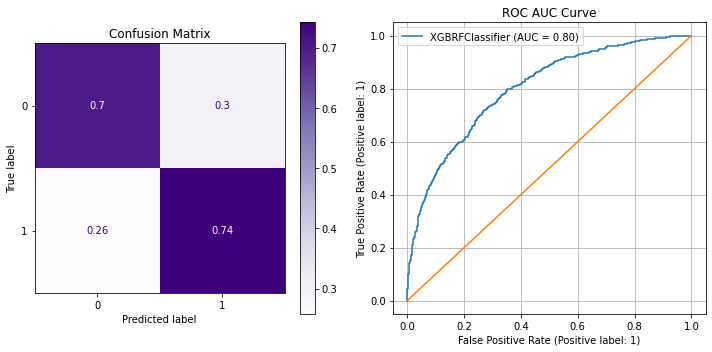

In [ ]:
# Fit and evaluate XGBoost on df_select.
xgb_select = fit_eval(XGBRFClassifier(random_state=42), \
                      X_train_select, y_train_select, \
                      X_test_select, y_test_select)

Применение на полном наборе данных (df_big)

****CLASSIFICATION REPORT - TRAINING DATA****
              precision    recall  f1-score   support

           0     0.7474    0.7730    0.7600      4203
           1     0.7644    0.7382    0.7511      4194

    accuracy                         0.7556      8397
   macro avg     0.7559    0.7556    0.7555      8397
weighted avg     0.7559    0.7556    0.7556      8397

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0     0.7216    0.7507    0.7359       746
           1     0.7365    0.7065    0.7212       736

    accuracy                         0.7287      1482
   macro avg     0.7291    0.7286    0.7285      1482
weighted avg     0.7290    0.7287    0.7286      1482

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


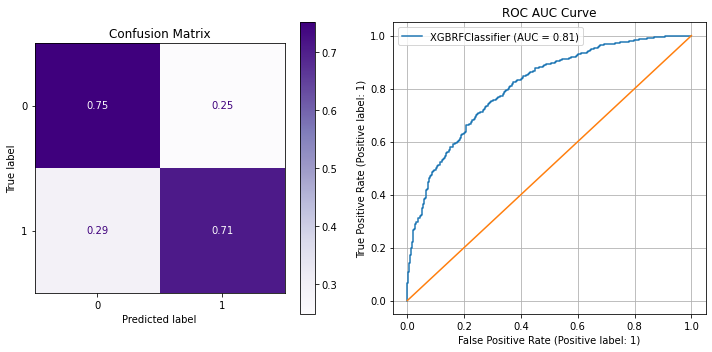

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', predictor=None, random_state=42,
                reg_alpha=None, ...)

In [ ]:

# Fit and evaluate XGBoost on df_big.
fit_eval(XGBRFClassifier(random_state=42), \
         X_train_big, y_train_big, X_test_big, y_test_big)

# Подбор гиперпараметров GridSearch CV - XGBoost: Random Forest на df_select
Далее мы попытаемся улучшить оценку recall в модели XGBoost, одновременно решая небольшую проблему переобучения. Хотя у нас был немного лучший показатель recall на df_big, где мы оставили параметры без изменений, улучшение оценки не стоит того, чтобы жертвовать объяснимостью признаков, поэтому мы продолжим с df_select.

In [ ]:
# Create parameter grid for XGBoost Random Forest gridsearch and fit to data.
xgb_rf = XGBRFClassifier(random_state=42)

params = {'learning_rate': [0.03, 0.05, 0.06],
          'max_depth': [4, 5, 6],
          'min_child_weight': [2, 3, 4],
          'subsample': [0.3, 0.4, 0.5],
          'n_estimators': [100]}
xgb_grid = GridSearchCV(xgb_rf, params, scoring='recall_macro')
xgb_grid.fit(X_train_select, y_train_select)

GridSearchCV(estimator=XGBRFClassifier(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bytree=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=None, gpu_id=None,
                                       grow_policy=None, importance_type=None,
                                       interaction_constraints=None,
                                       max_bin=None, max_cat_threshold=None,
                                       max_cat_...
                                       max_leaves=None, min_child_weight=None,
                                       missing=nan, monotone_constraints=None,
                                       n_estimators=100, n_jobs=None,
                                       num_parallel_tree=None,
                                       objective='binary:logistic',
                                       predictor=None, random_state=42,
                                       reg_alpha=None, ...),
             param_grid={'learning_rate': [0.03, 0.05, 0.06],
                         'max_depth': [4, 5, 6], 'min_child_weight': [2, 3, 4],
                         'n_estimators': [100], 'subsample': [0.3, 0.4, 0.5]},
             scoring='recall_macro')

In [ ]:
# лучшие параметры
xgb_grid.best_params_

{'learning_rate': 0.03,
 'max_depth': 6,
 'min_child_weight': 3,
 'n_estimators': 100,
 'subsample': 0.3}

****CLASSIFICATION REPORT - TRAINING DATA****
              precision    recall  f1-score   support

           0     0.7409    0.7321    0.7365      4203
           1     0.7347    0.7434    0.7390      4194

    accuracy                         0.7378      8397
   macro avg     0.7378    0.7378    0.7378      8397
weighted avg     0.7378    0.7378    0.7378      8397

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0     0.7376    0.7198    0.7286       746
           1     0.7228    0.7405    0.7315       736

    accuracy                         0.7301      1482
   macro avg     0.7302    0.7302    0.7301      1482
weighted avg     0.7303    0.7301    0.7301      1482

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


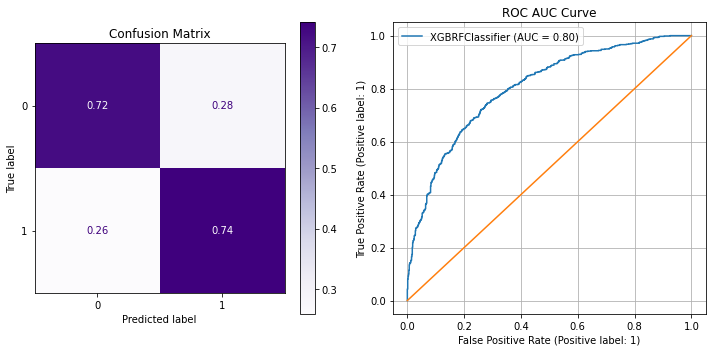

****MODEL PARAMETERS****


,parameters
colsample_bynode,0.8
learning_rate,0.03
reg_lambda,0.00001
subsample,0.3
objective,binary:logistic
use_label_encoder,None
base_score,None
booster,None
callbacks,None
colsample_bylevel,None


In [ ]:
# оценим модель с лучшими параметрами
evaluate_model(xgb_grid.best_estimator_, X_train_select, y_train_select, \
               X_test_select, y_test_select, params=True)

давайте посмотрим, сможем ли мы еще немного настроить гиперпараметры.

In [ ]:
# Create parameter grid for XGBoost Random Forest gridsearch and fit to data.
xgb_rf_ref = XGBRFClassifier(random_state=42)

params = {'learning_rate': [0.0001, 0.001],
          'max_depth': [6, 7, 8],
          'min_child_weight': [2, 3, 4],
          'subsample': [0.3, 0.5, 0.7],
          'n_estimators': [100]}
xgb_grid_refined = GridSearchCV(xgb_rf, params, scoring='recall_macro')
xgb_grid_refined.fit(X_train_select, y_train_select)

GridSearchCV(estimator=XGBRFClassifier(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bytree=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=None, gpu_id=None,
                                       grow_policy=None, importance_type=None,
                                       interaction_constraints=None,
                                       max_bin=None, max_cat_threshold=None,
                                       max_cat_...
                                       max_leaves=None, min_child_weight=None,
                                       missing=nan, monotone_constraints=None,
                                       n_estimators=100, n_jobs=None,
                                       num_parallel_tree=None,
                                       objective='binary:logistic',
                                       predictor=None, random_state=42,
                                       reg_alpha=None, ...),
             param_grid={'learning_rate': [0.0001, 0.001],
                         'max_depth': [6, 7, 8], 'min_child_weight': [2, 3, 4],
                         'n_estimators': [100], 'subsample': [0.3, 0.5, 0.7]},
             scoring='recall_macro')

In [ ]:
# лучшие параметры
xgb_grid_refined.best_params_

{'learning_rate': 0.001,
 'max_depth': 6,
 'min_child_weight': 3,
 'n_estimators': 100,
 'subsample': 0.3}

****CLASSIFICATION REPORT - TRAINING DATA****
              precision    recall  f1-score   support

           0     0.7409    0.7321    0.7365      4203
           1     0.7347    0.7434    0.7390      4194

    accuracy                         0.7378      8397
   macro avg     0.7378    0.7378    0.7378      8397
weighted avg     0.7378    0.7378    0.7378      8397

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0     0.7376    0.7198    0.7286       746
           1     0.7228    0.7405    0.7315       736

    accuracy                         0.7301      1482
   macro avg     0.7302    0.7302    0.7301      1482
weighted avg     0.7303    0.7301    0.7301      1482

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


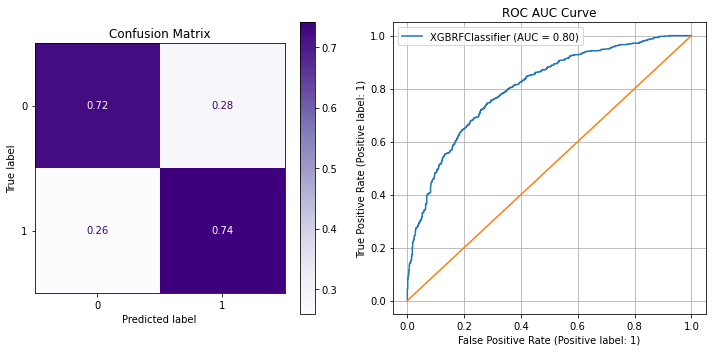

****MODEL PARAMETERS****


,parameters
colsample_bynode,0.8
learning_rate,0.001
reg_lambda,0.00001
subsample,0.3
objective,binary:logistic
use_label_encoder,None
base_score,None
booster,None
callbacks,None
colsample_bylevel,None


In [ ]:
# оценка лучшей модели
evaluate_model(xgb_grid_refined.best_estimator_, X_train_select, \
               y_train_select, X_test_select, y_test_select, params=True)

# XGBoost Random Forest важность признаков
рассмотрим ранжирование важности признаков из модели XGBoost.

In [ ]:
# Extract coefficients from log_grid.best_estimator_ model.
xgb_importance = pd.Series(xgb_grid_refined.best_estimator_.feature_importances_,
               index=X_train_select.columns).sort_values(ascending=False)
xgb_importance

blueDeaths                      0.212055
blueKills                       0.184805
blueAssists                     0.078521
redAssists                      0.063193
redDragons                      0.044934
blueDragons                     0.044832
redTotalMinionsKilled           0.040445
blueTotalMinionsKilled          0.038027
blueTowersDestroyed             0.036123
blueTotalJungleMinionsKilled    0.035911
redHeralds                      0.033115
redTotalJungleMinionsKilled     0.031116
blueHeralds                     0.028170
blueFirstBlood                  0.027691
redWardsPlaced                  0.024506
blueWardsDestroyed              0.022782
blueWardsPlaced                 0.022675
redWardsDestroyed               0.020332
redTowersDestroyed              0.010768
dtype: float32

## Визуализация важности признаков

<AxesSubplot:>

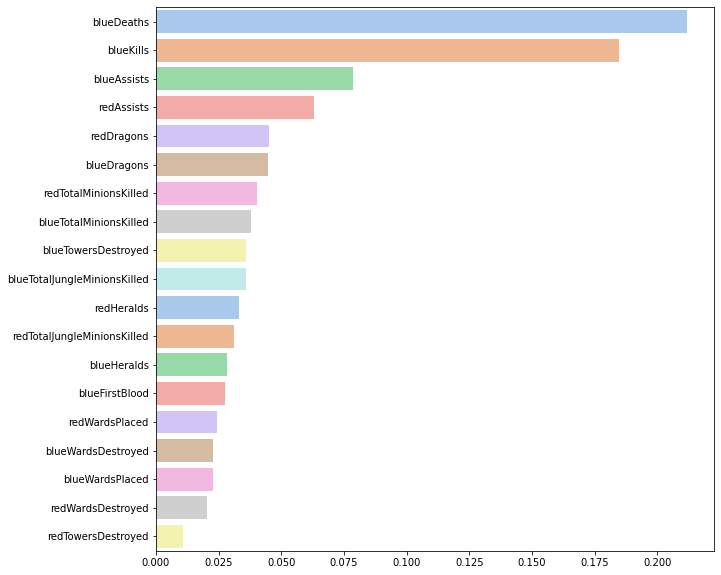

In [ ]:
# Create bar plot of feature importances.
fig, ax = plt.subplots(figsize=(10,10))

sns.barplot(x=xgb_importance.values, y=xgb_importance.index, palette='pastel', ax=ax, orient='h')


# Задание
на собранном ранее наборе данных (он может быть дополнен или собран новый)

- определить цель исследования
- разделить набор данных на тренировочный и тестовый 
- использовать классификацию Random Forest
- описать ход исследования дав пояснение и обоснование
- сделать выводы и определить практическое значение полученных знаний